# <b>Соревнование по сентимент-анализу отзывов</b>
[Kaggle Sentiment Analysis](https://www.kaggle.com/c/simplesentiment)

Due to the selected approach we will use PyTorch, Google Colab + GPU in our solution


There are various model architectures we can implement to do a sentiment analysis of sentences apart from baseline solution suggested in the class. For example:

- Logistic regression by converting words into vectors by using bag of words
- Random Forests build using nlp features
- Converting words into vectors using word embeddings and using RNN's
- Converting words into vectors using word embeddings and using CNN's
- Combing RNN's and CNN's

There are numerous number of NN architectures that can be used in sentiment analysys for our purposes. For instance, GPT-3, Elmo or BERT.

#### <b>BERT (Bidirectional Encoder Representations from Transformers)</b>

In 2018, Google AI released a model called BERT. If you don't know what BERT is, please go through the following links:

- [Paper: "BERT: Pre-training of Deep Bidirectional Transformers forLanguage Understanding"](https://arxiv.org/pdf/1810.04805.pdf)

BERT obtains new state-of-the-art results on eleven natural language processing tasks.

#### <b>RoBERTa: A Robustly Optimized BERT Pretraining Approach</b>

- [Paper](https://arxiv.org/abs/1907.11692)
- [Facebook Blog](https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/)


 We will use the state-of-the-art model architecture <b>ROBERTA</b> implemented in PyTorch and created by Facebook AI team which proposed an 'optimized' and 'robust' version of BERT in 2019.

It essentially includes fine-tuning the original BERT model along with data and inputs manipulation.

![image.png](https://miro.medium.com/max/700/1*bSUO_Qib4te1xQmBlQjWaw.png)

#### <b>Data</b>

It has been observed that training BERT on larger datasets, greatly improves its performance. So RoBERTa is trained on a vast dataset that goes over 160GB of uncompressed text. This dataset is composed of the following corpora:

1. BookCorpus + English Wikipedia (16GB): This is the data on which BERT is trained.
2. CC-News (76GB): The authors have collected this data from the English portion of the CommonCrawl News Data. It contains 63M English news articles crawled between September 2016 and February 2019.
3. OpenWebText (38GB): Open Source recreation of the WebText dataset used to train OpenAI GPT.
4. Stories (31GB): A subset of CommonCrawl data filtered to match the story-like style of Winograd schemas.

### <b>1. Install and import libraries</b>

First, let's install and import necessary libraries like [nltk](https://www.nltk.org/) to perform basic text preprocessing and 
state-of-the-art Natural Language Processing for PyTorch  [transformers](https://github.com/huggingface/transformers) library by <img src="https://github.githubassets.com/images/icons/emoji/unicode/1f917.png" alt="huggingface" title="huggingface" width="15">.

<img src="https://github.githubassets.com/images/icons/emoji/unicode/1f917.png" width="15" title="huggingface"> Huggingface Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation, etc in 100+ languages. Its aim is to make cutting-edge NLP easier to use for everyone.

In [1]:
!pip3 install transformers nltk

     |████████████████████████████████| 1.4MB 10.0MB/s 
     |████████████████████████████████| 890kB 31.5MB/s 
     |████████████████████████████████| 2.9MB 41.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c482a3cf6e099d3b81eafc9fe0b8d3a5907156de36601ea8cc401fc5ac755973
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import csv
import logging
import sys
import random
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from torch.nn import CrossEntropyLoss
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import StratifiedShuffleSplit

from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig, RobertaModel, AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
csv.field_size_limit(2147483647)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


131072

Authorize Google Drive in Colab and mount drive in order to use our datasets

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We'll use a GPU in our training process, so let's check which GPU we are using in a kernel by typing <code>!nvidia-smi<code>

In [4]:
!nvidia-smi

Wed Dec  2 00:07:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Set device to CUDA if GPU is avaliable, else set CPU to perform calculations

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Initialize <code>preprocess</code> function to perform a basic clean of our dataset, remove HTML tags, numbers, punctuation and put sentences to lowercase

### <b>2. Load data</b>

In [6]:
def preprocess(text):
  
  new_text = re.sub('<.*?>', '', text) # remove html tags
  new_text = re.sub(r'[^\w\s]', '', new_text) # remove punctiation
  new_text = re.sub(fr'\b\d+\b', '', new_text ) # remove numbers (not if they're in words)
  
  new_text = new_text.lower() # lowercase sentences      

  return new_text

Load our dataset for ROBERTA fine-tuning on 2000 examples. 

Also let's see if our classes are imbalanced ("0" and "1") by visualizing classes distribution using Matplotlib and pie chart

In [7]:
train_df = pd.read_csv('/content/gdrive/My Drive/products_sentiment_train.tsv', sep='\t', header=None)
train_df = train_df.reset_index()
train_df.columns = ['id', 'text', 'label']
train_df['label'] = train_df['label'].astype(str)

train_df

,id,text,label
0,0,"2 . take around 10,000 640x480 pictures .",1
1,1,i downloaded a trial version of computer assoc...,1
2,2,the wrt54g plus the hga7t is a perfect solutio...,1
3,3,i dont especially like how music files are uns...,0
4,4,i was using the cheapie pail ... and it worked...,1
...,...,...,...
1995,1995,"speaker phone quality is good , and poping in ...",1
1996,1996,"the "" movies "" last about 5 seconds .",0
1997,1997,overall i like it .,1
1998,1998,i began taking pics as soon as i got this came...,1


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


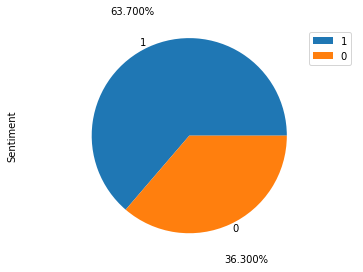

In [8]:
train_df.label.value_counts().plot(kind='pie', label='Sentiment',
                                       autopct='%.3f%%', pctdistance=1.4, labeldistance=1.05)
plt.legend()
plt.axis('equal')
plt.show()

Classes are imbalanced relatively about 2 to 1, so it is neccessary to balance our data by either:

1. Using NLP Data Augmentation
2. Oversampling minority class
3. Undersampling majotiry class
4. Use Weighted Loss function, e.g. Weighted BinaryCrossEntropy

In [9]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x)).astype(str)
train_df

,id,text,label
0,0,take around 640x480 pictures,1
1,1,i downloaded a trial version of computer assoc...,1
2,2,the wrt54g plus the hga7t is a perfect solutio...,1
3,3,i dont especially like how music files are uns...,0
4,4,i was using the cheapie pail and it worked ok...,1
...,...,...,...
1995,1995,speaker phone quality is good and poping in a...,1
1996,1996,the movies last about seconds,0
1997,1997,overall i like it,1
1998,1998,i began taking pics as soon as i got this came...,1


### <b>3. Roberta model </b>

In [10]:
# Class representing a single example object

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


# Class representing input features of a single example object

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [11]:
# Data PreProcessor class, which creates train and test examples objects

class DataPreProcessor():
    
    def get_labels(self):
        """Returns all the types of labels present in the data."""
        
        return ["0", "1"]
    
    def get_train_examples(self, data):
        """Creates the examples for the given data."""
        examples = []
        
        for (i, line) in enumerate(data.values.tolist()):
            
            guid = line[0]
            text_a = line[1]
            label = line[-1]
            
            examples.append(InputExample(guid=guid, text_a=text_a, label=label))
        
        return examples

    def get_dev_examples(self, data):
        """Creates the examples for the given data."""
        examples = []
        
        for (i, line) in enumerate(data.values.tolist()):
            
            guid = line[0]
            text_a = line[1]
            label = line[-1]
            
            examples.append(InputExample(guid=guid, text_a=text_a, label=label))
        
        return examples

Description of basic parameters and hyperparameters of our fine-tuned ROBERTA model

In [12]:
output_mode = 'classification' # or regression
roberta_model = 'roberta-base' # model to use: bert, roberta, xl, xlm-roberta, etc

train_batch_size = 32 # batch size for training(8, 16, 64, 128, ...), depends on GPU and memory management, less GPU memory -> less batch size
gradient_accumulation_steps = 1 # batch at each step will be divided by this integer and gradient will be accumulated over
max_grad_norm = 1.0 # parameter for clipping gradients, otherwise their value might explode
num_train_epochs = 3.0 # epochs

learning_rate = 1e-5 # adam optimizer learning rate
warmup_proportion = 0.1 # learning rate value linear warmup proportion
num_training_steps = 1000
num_warmup_steps = 100
max_seq_length = 256 # maximum sequence length of an input sentence, max value is: 512

eval_batch_size = 8 # batch size for evaluation

cache_dir = os.path.join("", "pytorch_pretrained_models")
output_dir = os.path.join("", "out_dir") 

In [13]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Initialize DataProcessor for our training set and download ROBERTA tokenizer

In [14]:
processor = DataPreProcessor() # data preprocessor

label_list = processor.get_labels() # label list, e.g [0, 1, C], where C is number of classes
num_labels = len(label_list)

tokenizer = RobertaTokenizer.from_pretrained(roberta_model) # roberta tokenizer

INFO:filelock:Lock 139679408878200 acquired on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


INFO:filelock:Lock 139679408878200 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


INFO:filelock:Lock 139679428625016 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


INFO:filelock:Lock 139679428625016 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Use Regularization

Paper: [Scheduled DropHead: A Regularization Method for Transformer Models](https://arxiv.org/pdf/2004.13342.pdf)

In [15]:
VALID_CLS = (RobertaModel)


def _drophead_hook(module, input, output):
    """
    Pytorch forward hook for transformers.modeling_bert.BertSelfAttention layer
    """
    if (not module.training) or (module.p_drophead==0):
        return output

    orig_shape = output[0].shape
    dist = torch.distributions.Bernoulli(torch.tensor([1-module.p_drophead]))
    mask = dist.sample((orig_shape[0], module.num_attention_heads))
    mask = mask.to(output[0].device).unsqueeze(-1)
    count_ones = mask.sum(dim=1).unsqueeze(-1)  # calc num of active heads

    self_att_out = module.transpose_for_scores(output[0])
    self_att_out = self_att_out * mask * module.num_attention_heads / count_ones
    self_att_out = self_att_out.permute(0, 2, 1, 3).view(*orig_shape)
    return (self_att_out,) + output[1:]


def valid_type(obj):
    return isinstance(obj, VALID_CLS)


def get_base_model(model):
    """
    Check model type. If correct then return the model itself.
    If not correct then try to find in attributes and return correct type
    attribute if found
    """
    if not valid_type(model):
        attrs = [name for name in dir(model) if valid_type(getattr(model, name))]
        if len(attrs) == 0:
            raise ValueError("Please provide valid model")
        model =  getattr(model, attrs[0])
    return model


def set_drophead(model, p=0.1):
    """
    Adds drophead to model. Works inplace.
    Args:
        model: an instance of transformers.BertModel / transformers.RobertaModel /
            transformers.XLMRobertaModel or downstream model (e.g. transformers.BertForSequenceClassification)
            or any custom downstream model
        p: drophead probability
    """
    if (p < 0) or (p > 1):
        raise ValueError("Wrong p argument")

    model = get_base_model(model)

    for bert_layer in model.encoder.layer:
        if not hasattr(bert_layer.attention.self, "p_drophead"):
            bert_layer.attention.self.register_forward_hook(_drophead_hook)
        bert_layer.attention.self.p_drophead = p

### <b>4. Fine-tune Roberta on our dataset</b>

In [16]:
train_examples = processor.get_train_examples(train_df) # create train examples collection

In [17]:
num_train_optimization_steps = int(len(train_examples) / train_batch_size / gradient_accumulation_steps) * num_train_epochs
print(num_train_optimization_steps)

186.0


In [18]:
model = RobertaForSequenceClassification.from_pretrained(roberta_model, cache_dir=cache_dir, num_labels=num_labels) # download roberta-base model

INFO:filelock:Lock 139679389975832 acquired on pytorch_pretrained_models/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


INFO:filelock:Lock 139679389975832 released on pytorch_pretrained_models/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


INFO:filelock:Lock 139679387995216 acquired on pytorch_pretrained_models/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


INFO:filelock:Lock 139679387995216 released on pytorch_pretrained_models/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [19]:
set_drophead(model, p=0.07)

In [20]:
model.to(device) # set model on GPU

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [21]:
param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# adam optimizer
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, correct_bias=False) 

# scheduler for tuning learning rate over training time
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_optimization_steps)

In [22]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [23]:
from transformers import glue_convert_examples_to_features as convert_examples_to_features

# create training features that roberta model understands
train_features = convert_examples_to_features(
    train_examples,
    tokenizer,
    max_length=max_seq_length,
    label_list=label_list,
    output_mode='classification'
)

/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [24]:
print("***** Running training *****")
print("Num examples =", len(train_examples))
print("Batch size =", train_batch_size)
print("Num steps =", num_train_optimization_steps)

***** Running training *****
Num examples = 2000
Batch size = 32
Num steps = 186.0


In [25]:
# create a training dataset for pytorch using dataloader

all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in train_features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in train_features], dtype=torch.long)

train_data = TensorDataset(all_input_ids, all_attention_mask, all_labels)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

In [26]:
# train model with batch size = 32 with binary crossentropy loss

model.train()

weights = torch.tensor([2, 1], dtype=torch.float, device=device)

for _ in trange(int(num_train_epochs), desc='Epoch'):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)

        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        
        input_ids = batch[0]
        label_ids = batch[2]
        
        outputs = model(**inputs)
        
        logits = outputs[1]
        
        loss_fct = CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()
        global_step += 1
        
    print("Training Loss: %s" % (str(tr_loss)))

Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

Training Loss: 38.55598162859678



Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

Training Loss: 20.06460191309452



Epoch: 100%|██████████| 3/3 [04:24<00:00, 88.26s/it]

Training Loss: 11.961962923407555


Save finetuned model to output directory, then use it for training on our dataset

In [27]:
model_to_save = model.module if hasattr(model, 'module') else model 
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

model = RobertaForSequenceClassification.from_pretrained(output_dir)
tokenizer = RobertaTokenizer.from_pretrained(output_dir)

model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

### <b>5. Evaluate model on Test dataset</b>


In [28]:
test_df = pd.read_csv('/content/gdrive/My Drive/products_sentiment_test.tsv', sep='\t')

test_df['label'] = 0
test_df['label'] = test_df['label'].astype(str)
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x)).astype(str)

test_df.head()

,Id,text,label
0,0,so why the small digital elph rather than on...,0
1,1,way through the first disk we played on it n...,0
2,2,better for the zen micro is outlook compatibil...,0
3,3,play gameboy color games on it with goboy,0
4,4,likewise i ve heard norton professional vers...,0


In [29]:
test_examples = processor.get_dev_examples(test_df)

test_features = convert_examples_to_features(
    test_examples,
    tokenizer,
    max_length=max_seq_length,
    label_list=label_list,
    output_mode='classification'
)

/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [30]:
all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in test_features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in test_features], dtype=torch.long)

test_batch_size = 8

test_data = TensorDataset(all_input_ids, all_attention_mask, all_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=test_batch_size)

test_loss = 0
nb_test_steps = 0
preds = []

In [31]:
model.eval()

for batch in tqdm(test_dataloader, desc="Predicting"):
    batch = tuple(t.to(device) for t in batch)

    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        
    input_ids = batch[0]
    label_ids = batch[2]

    with torch.no_grad():
        outputs = model(**inputs)
        
    logits = outputs[1]

    # create eval loss and other metric required by the task
    loss_fct = CrossEntropyLoss()
    
    tmp_test_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    test_loss += tmp_test_loss.mean().item()
    
    nb_test_steps += 1
    
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(preds[0], logits.detach().cpu().numpy(), axis=0)

test_loss = test_loss / nb_test_steps

print('test loss', test_loss)

preds = preds[0]
preds = np.argmax(preds, axis=1)

print(preds.shape)

print(preds)

Predicting: 100%|██████████| 63/63 [00:07<00:00,  8.25it/s]

test loss 2.573207563824124
(500,)
[0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0
 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0
 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1
 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1
 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0
 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0
 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 

 ### <b>6. Create Submission</b>


Make a CSV submission file for Kaggle using model predictions

In [32]:
submission = test_df.copy()
submission.drop('text', axis=1, inplace=True)
submission.label = preds
submission.columns = ['Id', 'y']
submission

,Id,y
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
495,495,0
496,496,1
497,497,0
498,498,1


Save submission to CSV in order to load at Kaggle

In [33]:
submission.to_csv('submission.csv', index=None)